In [2]:
# 0. 환경 준비
import os, math, json, random, time
from dataclasses import dataclass
from typing import Tuple, Dict, List

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)


DEVICE: cuda


In [10]:
pip install --upgrade torch


Note: you may need to restart the kernel to use updated packages.


In [3]:
# 1. 더미 데이터 생성 (상점별 월간 지표)
# - 상점 수: 300
# - 기간: 48개월 (2019-01 ~ 2022-12) 예시
# - 타깃: 다음달 'visits' (연속값)
# - 외생 변수: 프로모션, 이벤트, 카테고리, 지역 및 계절성/추세

n_stores = 300
months = pd.period_range("2019-01", "2022-12", freq="M")  # 48개월
store_ids = [f"S{i:04d}" for i in range(n_stores)]
categories = ["cafe","pizza","korean","japanese","chicken","burger","dessert"]
regions = ["north","south","east","west","center"]

rows = []
rng = np.random.default_rng(SEED)

for sid in store_ids:
    cat = rng.choice(categories)
    reg = rng.choice(regions)

    # 고유 베이스 수요 + 추세 + 계절성
    base = rng.uniform(50, 300)
    trend = rng.uniform(-0.5, 1.2)  # 월별 증가/감소
    season_amp = rng.uniform(10, 80)
    noise_sigma = rng.uniform(5, 20)

    # 카테/지역 버프
    cat_boost = {"cafe":20,"pizza":10,"korean":35,"japanese":25,"chicken":30,"burger":15,"dessert":18}[cat]
    reg_boost = {"north":10,"south":5,"east":8,"west":12,"center":20}[reg]

    level = base + cat_boost + reg_boost

    # 월별 루프
    for t, p in enumerate(months):
        m = p.month

        # 계절성(연간 주기) + 이벤트(확률적으로 +증가)
        seasonal = season_amp * math.sin(2*math.pi*(m/12.0))
        promo_flag = (rng.random() < 0.18)  # 18% 달에 프로모션
        event_flag = (rng.random() < 0.08)  # 지역 행사

        promo_effect = 1.0 + (0.15 if promo_flag else 0.0)
        event_effect = 1.0 + (0.10 if event_flag else 0.0)

        # 관측값: visits/sales/reviews 등 서로 상관되도록 구성
        visits = max(
            5,
            level + trend*t + seasonal + rng.normal(0, noise_sigma)
        ) * promo_effect * event_effect

        sales = visits * rng.uniform(9.0, 13.0)   # 평균 객단가
        reviews = max(0, rng.poisson(visits/40))  # 리뷰는 방문수의 일부
        rating = np.clip(rng.normal(4.2, 0.3) - 0.0005*max(0, 200-visits), 2.5, 5.0)
        favs = max(0, rng.poisson(visits/15))
        views = visits * rng.uniform(4.0, 7.0)

        rows.append({
            "storeId": sid,
            "yearMonth": str(p),  # '2019-01'
            "year": p.year, "month": m,
            "category": cat, "region": reg,
            "promo_flag": int(promo_flag),
            "event_flag": int(event_flag),
            "visits": float(visits),
            "sales": float(sales),
            "reviews": int(reviews),
            "rating": float(rating),
            "favs": int(favs),
            "views": float(views),
        })

raw = pd.DataFrame(rows).sort_values(["storeId","yearMonth"]).reset_index(drop=True)
raw.head(), raw.shape


(  storeId yearMonth  year  month category region  promo_flag  event_flag  \
 0   S0000   2019-01  2019      1     cafe   west           0           0   
 1   S0000   2019-02  2019      2     cafe   west           0           0   
 2   S0000   2019-03  2019      3     cafe   west           0           0   
 3   S0000   2019-04  2019      4     cafe   west           0           0   
 4   S0000   2019-05  2019      5     cafe   west           0           0   
 
        visits        sales  reviews    rating  favs        views  
 0  219.099535  2084.174361        8  4.463535    16  1109.427563  
 1  240.868450  2355.345342        3  4.842494    27  1231.169964  
 2  251.723899  2744.500282        9  4.461429    12  1012.455372  
 3  236.190158  2863.313478        5  3.695139    19  1337.010652  
 4  222.729701  2393.647048        4  4.349148    12  1263.121621  ,
 (14400, 14))

In [4]:
# 2. 피처 엔지니어링
# - 타깃 y: 다음달 visits
# - 라그/이동평균/증감률
# - 월 임베딩(사인/코사인)
# - 원-핫: 카테고리/지역
# - 스케일링: 수치형만 글로벌 표준화 + 상점 평균/표준편차 보정 옵션

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # 월 주기 임베딩
    df["month_sin"] = np.sin(2*np.pi*(df["month"]/12))
    df["month_cos"] = np.cos(2*np.pi*(df["month"]/12))
    return df

def add_lags_rolls(df: pd.DataFrame, group_cols=["storeId"], target_cols=["visits","sales","reviews","favs","views","rating"]):
    df = df.copy()
    df["y_next"] = df.groupby(group_cols)["visits"].shift(-1)  # 다음달 visits가 타깃

    for c in target_cols:
        for L in [1,2,3]:
            df[f"{c}_lag{L}"] = df.groupby(group_cols)[c].shift(L)
        for w in [3,6]:
            df[f"{c}_ma{w}"] = df.groupby(group_cols)[c].rolling(w, min_periods=1).mean().reset_index(0,drop=True)
        # 증감률(라그1 기준)
        df[f"{c}_chg"] = (df[c] - df.groupby(group_cols)[c].shift(1)) / (df.groupby(group_cols)[c].shift(1) + 1e-6)

    return df

def one_hot(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    return pd.get_dummies(df, columns=cols, drop_first=True)

feat = add_time_features(raw)
feat = add_lags_rolls(feat)

# 학습에 사용할 칼럼 선택
num_cols = [c for c in feat.columns if any(k in c for k in [
    "visits","sales","reviews","favs","views","rating","month_sin","month_cos","_lag","_ma","_chg"
]) and ("y_next" not in c)]

cat_cols = ["category","region"]
keep_cols = ["storeId","yearMonth","year","month","promo_flag","event_flag","y_next"] + num_cols + cat_cols

feat = feat[keep_cols].dropna().reset_index(drop=True)  # 라그 생성으로 NaN 생김 → 제거
feat = one_hot(feat, cat_cols)

print("Feature shape:", feat.shape)
feat.head()


Feature shape: (13200, 61)


,storeId,yearMonth,year,month,promo_flag,event_flag,y_next,visits,sales,reviews,...,category_cafe,category_chicken,category_dessert,category_japanese,category_korean,category_pizza,region_east,region_north,region_south,region_west
0,S0000,2019-04,2019,4,0,0,222.729701,236.190158,2863.313478,5,...,True,False,False,False,False,False,False,False,False,True
1,S0000,2019-05,2019,5,0,0,194.533958,222.729701,2393.647048,4,...,True,False,False,False,False,False,False,False,False,True
2,S0000,2019-06,2019,6,0,0,170.932880,194.533958,2384.224051,1,...,True,False,False,False,False,False,False,False,False,True
3,S0000,2019-07,2019,7,0,0,141.514008,170.932880,1843.447033,4,...,True,False,False,False,False,False,False,False,False,True
4,S0000,2019-08,2019,8,0,0,149.964444,141.514008,1427.730052,3,...,True,False,False,False,False,False,False,False,False,True


In [5]:
# 3. 학습/검증/테스트 분할 (시간 기반)
# - 마지막 6개월: 테스트
# - 그 이전 6개월: 검증
# - 나머지: 학습
# - 월별 분할은 모든 상점에 동일하게 적용 (데이터 누수 방지)

all_months = sorted(feat["yearMonth"].unique().tolist())
test_months = all_months[-6:]
val_months  = all_months[-12:-6]
train_months = all_months[:-12]

def split_by_month(df, months_set):
    return df[df["yearMonth"].isin(months_set)].copy()

train_df = split_by_month(feat, set(train_months))
val_df   = split_by_month(feat, set(val_months))
test_df  = split_by_month(feat, set(test_months))

y_col = "y_next"
x_cols = [c for c in feat.columns if c not in ["storeId","yearMonth","year","month",y_col]]

len(train_df), len(val_df), len(test_df), len(x_cols)


(9600, 1800, 1800, 56)

In [6]:
# 4. 스케일링 (수치형만 표준화; 이진/원핫은 그대로)
# - 학습셋 기준으로 fit → 검증/테스트에 transform

def split_numeric_binary(df, cols):
    # 이진/카테 원핫은 0/1이므로 스케일 제외
    numeric_cols = []
    binary_cols  = []
    for c in cols:
        if set(df[c].dropna().unique()).issubset({0,1}):
            binary_cols.append(c)
        else:
            numeric_cols.append(c)
    return numeric_cols, binary_cols

numcols_train, bincols_train = split_numeric_binary(train_df, x_cols)
scaler = StandardScaler()
scaler.fit(train_df[numcols_train])

def transform(df):
    X_num = scaler.transform(df[numcols_train])
    X_bin = df[bincols_train].values
    X = np.concatenate([X_num, X_bin], axis=1)
    y = df[y_col].values.astype(np.float32)
    return X.astype(np.float32), y

X_train, y_train = transform(train_df)
X_val,   y_val   = transform(val_df)
X_test,  y_test  = transform(test_df)

print(X_train.shape, X_val.shape, X_test.shape)


(9600, 56) (1800, 56) (1800, 56)


In [7]:
# 5. 텐서로 변환 + (선택) 시퀀스 샘플링
# 여기서는 LSTM 입력을 "최근 T 타임스텝 묶음"으로 만들기 위해
# 같은 상점 내에서 연속된 T개월을 윈도우로 잘라 Dataset 구성

SEQ_LEN = 6  # 최근 6개월의 피처 → 다음달 y 예측

# 원본 DF에서 상점별 시퀀스로 다시 묶어 샘플 생성
feature_cols_all = numcols_train + bincols_train

def build_sequence_samples(df: pd.DataFrame, seq_len: int) -> Tuple[np.ndarray, np.ndarray]:
    samples_X, samples_y = [], []
    for sid, g in df.sort_values(["storeId","year","month"]).groupby("storeId"):
        g = g.reset_index(drop=True)
        Xg = np.concatenate([
            scaler.transform(g[numcols_train]),
            g[bincols_train].values
        ], axis=1).astype(np.float32)
        yg = g[y_col].values.astype(np.float32)

        for i in range(len(g) - seq_len + 1):
            j = i + seq_len - 1
            # 시퀀스의 마지막 시점의 타깃을 사용 (y_next는 이미 각 행에 위치)
            x_seq = Xg[i:i+seq_len]
            y_tar = yg[j]
            samples_X.append(x_seq)
            samples_y.append(y_tar)
    return np.stack(samples_X), np.array(samples_y)

Xtr_seq, ytr_seq = build_sequence_samples(train_df, SEQ_LEN)
Xva_seq, yva_seq = build_sequence_samples(val_df,   SEQ_LEN)
Xte_seq, yte_seq = build_sequence_samples(test_df,  SEQ_LEN)

Xtr_seq.shape, Xva_seq.shape, Xte_seq.shape


((8100, 6, 56), (300, 6, 56), (300, 6, 56))

In [8]:
# 6. PyTorch Dataset / DataLoader
class SeqDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), torch.tensor(self.y[i])

BATCH = 256
train_loader = DataLoader(SeqDataset(Xtr_seq, ytr_seq), batch_size=BATCH, shuffle=True, drop_last=False)
val_loader   = DataLoader(SeqDataset(Xva_seq, yva_seq), batch_size=BATCH, shuffle=False, drop_last=False)
test_loader  = DataLoader(SeqDataset(Xte_seq, yte_seq), batch_size=BATCH, shuffle=False, drop_last=False)

in_dim = Xtr_seq.shape[-1]
in_dim


56

In [9]:
# 7. LSTM 모델 정의
class StoreLSTM(nn.Module):
    def __init__(self, in_dim, hidden=128, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=in_dim,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout
        )
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden//2, 1)
        )

    def forward(self, x):
        # x: (B, T, in_dim)
        o, _ = self.lstm(x)
        last = o[:, -1, :]
        y = self.head(last).squeeze(-1)
        return y

model = StoreLSTM(in_dim=in_dim, hidden=128, layers=2, dropout=0.2).to(DEVICE)
sum(p.numel() for p in model.parameters())/1e6, model


(0.235649,
 StoreLSTM(
   (lstm): LSTM(56, 128, num_layers=2, batch_first=True, dropout=0.2)
   (head): Sequential(
     (0): Linear(in_features=128, out_features=64, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.2, inplace=False)
     (3): Linear(in_features=64, out_features=1, bias=True)
   )
 ))

[01] train 432.3154 | val RMSE 235.18 MAPE 94.68%
[02] train 398.9650 | val RMSE 216.44 MAPE 84.49%
[03] train 353.5062 | val RMSE 192.45 MAPE 71.30%
[04] train 296.9295 | val RMSE 163.53 MAPE 55.40%
[05] train 235.3375 | val RMSE 131.13 MAPE 40.71%
[06] train 180.3260 | val RMSE 99.85 MAPE 33.09%
[07] train 150.4780 | val RMSE 83.57 MAPE 36.07%
[08] train 121.4832 | val RMSE 58.04 MAPE 18.36%
[09] train 70.9541 | val RMSE 33.88 MAPE 10.46%
[10] train 53.9580 | val RMSE 27.39 MAPE 10.26%
[11] train 50.6518 | val RMSE 23.76 MAPE 8.09%
[12] train 49.7542 | val RMSE 23.73 MAPE 8.37%
[13] train 48.2074 | val RMSE 23.21 MAPE 8.13%
[14] train 47.4692 | val RMSE 25.58 MAPE 8.18%
[15] train 47.6087 | val RMSE 22.98 MAPE 7.88%
[16] train 46.8560 | val RMSE 22.82 MAPE 8.01%
[17] train 46.4701 | val RMSE 22.86 MAPE 7.87%
[18] train 46.5469 | val RMSE 22.67 MAPE 7.89%
[19] train 46.8558 | val RMSE 21.93 MAPE 7.71%
[20] train 45.7671 | val RMSE 22.12 MAPE 8.03%
[21] train 46.0710 | val RMSE 22.06 M

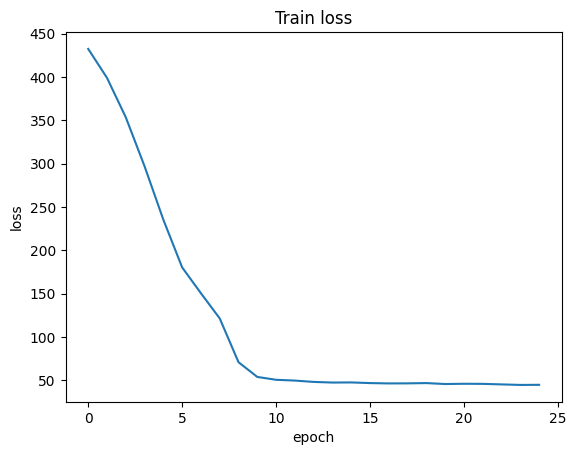

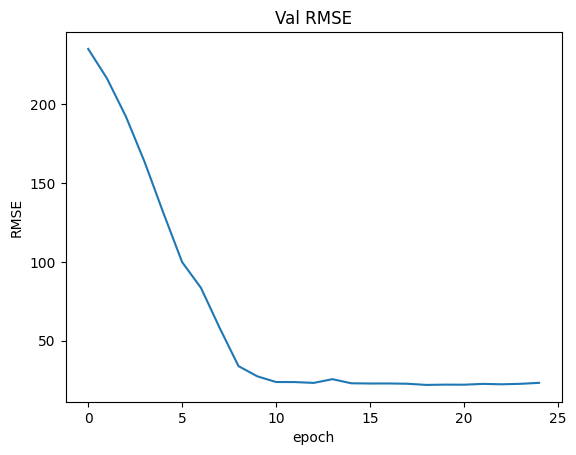

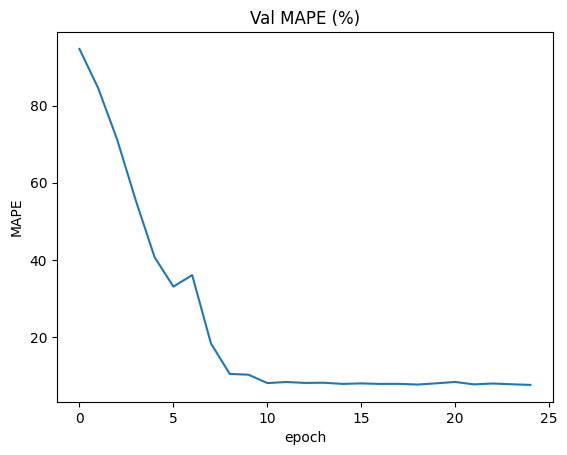

In [11]:
# 8. 학습 루프 (조기 종료 + 스케줄러)  -- verbose 호환 버전
def mape(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred)/(y_true+eps))) * 100

def evaluate(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(DEVICE); yb = yb.to(DEVICE)
            out = model(Xb)
            preds.append(out.detach().cpu().numpy())
            trues.append(yb.detach().cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    rmse = math.sqrt(mean_squared_error(trues, preds))
    mape_v = mape(trues, preds)
    return rmse, mape_v, preds, trues

def topn_precision(preds, trues, n_ratio=0.1):
    N = int(len(preds) * n_ratio)
    idx_pred_top = np.argsort(-preds)[:N]
    idx_true_top = np.argsort(-trues)[:N]
    s_pred = set(idx_pred_top.tolist()); s_true = set(idx_true_top.tolist())
    if N == 0: return np.nan
    return len(s_pred & s_true) / N

lr = 1e-3
opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=3)
loss_fn = nn.HuberLoss(delta=2.0)

EPOCHS = 30
best_val = float("inf")
patience = 6
wait = 0
history = {"train_loss": [], "val_rmse": [], "val_mape": []}

# 최근 LR 추적(변경될 때만 출력)
def get_lr(optimizer):
    return optimizer.param_groups[0]["lr"]

last_lr = get_lr(opt)

for epoch in range(1, EPOCHS+1):
    model.train()
    batch_losses = []
    for Xb, yb in train_loader:
        Xb = Xb.to(DEVICE); yb = yb.to(DEVICE)
        opt.zero_grad()
        out = model(Xb)
        loss = loss_fn(out, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        batch_losses.append(loss.item())

    # 검증
    rmse, mape_v, p, t = evaluate(model, val_loader)
    scheduler.step(rmse)

    # LR 변화 시에만 알림(verbose 대체)
    current_lr = get_lr(opt)
    lr_note = ""
    if abs(current_lr - last_lr) > 1e-12:
        lr_note = f" | LR reduced → {current_lr:.2e}"
        last_lr = current_lr

    train_loss = float(np.mean(batch_losses))
    history["train_loss"].append(train_loss)
    history["val_rmse"].append(rmse)
    history["val_mape"].append(mape_v)

    print(f"[{epoch:02d}] train {train_loss:.4f} | val RMSE {rmse:.2f} MAPE {mape_v:.2f}%{lr_note}")

    # 조기 종료
    if rmse < best_val - 1e-3:
        best_val = rmse
        wait = 0
        torch.save(model.state_dict(), "best_lstm.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping")
            break

# 학습 곡선
plt.figure(); plt.plot(history["train_loss"]); plt.title("Train loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.show()
plt.figure(); plt.plot(history["val_rmse"]); plt.title("Val RMSE"); plt.xlabel("epoch"); plt.ylabel("RMSE"); plt.show()
plt.figure(); plt.plot(history["val_mape"]); plt.title("Val MAPE (%)"); plt.xlabel("epoch"); plt.ylabel("MAPE"); plt.show()


TEST  RMSE: 25.82 | MAPE: 9.05% | Top10% P: 0.633 | Top20% P: 0.850


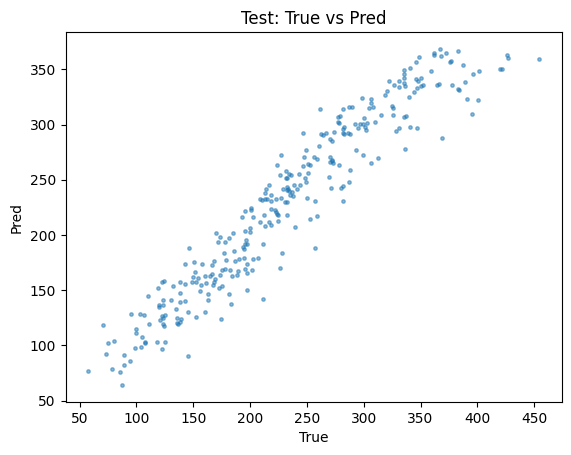

In [12]:
# 9. 테스트 평가
best = StoreLSTM(in_dim=in_dim, hidden=128, layers=2, dropout=0.2).to(DEVICE)
best.load_state_dict(torch.load("best_lstm.pt", map_location=DEVICE))
rmse_te, mape_te, preds_te, trues_te = evaluate(best, test_loader)
prec10 = topn_precision(preds_te, trues_te, n_ratio=0.10)
prec20 = topn_precision(preds_te, trues_te, n_ratio=0.20)

print(f"TEST  RMSE: {rmse_te:.2f} | MAPE: {mape_te:.2f}% | Top10% P: {prec10:.3f} | Top20% P: {prec20:.3f}")

# 산포도 확인
plt.figure()
plt.scatter(trues_te, preds_te, s=6, alpha=0.5)
plt.title("Test: True vs Pred")
plt.xlabel("True"); plt.ylabel("Pred")
plt.show()


In [13]:
# 10. 예측 결과를 상점 단위 랭킹으로 만들어 보기 (다음 단계 연결용)
# 주의: 위의 시퀀스 샘플은 샘플 순서가 상점/월이 섞여 있음.
# 여기서는 간단히 "테스트셋 예측값 상위 N%"를 랭킹으로 변환하는 예시만 제공합니다.

N = int(len(preds_te) * 0.10)
rank_idx = np.argsort(-preds_te)[:N]

ranking_df = pd.DataFrame({
    "true": trues_te,
    "pred": preds_te,
})
ranking_df["rank"] = ranking_df["pred"].rank(ascending=False, method="first")
ranking_top = ranking_df.sort_values("rank").head(N).reset_index(drop=True)
ranking_top.head(10)


,true,pred,rank
0,367.341309,368.477295,1.0
1,383.288544,366.557587,2.0
2,372.299591,364.920624,3.0
3,361.809082,364.831116,4.0
4,362.295715,363.245087,5.0
5,425.687622,363.008606,6.0
6,367.808746,361.646698,7.0
7,348.692963,360.959991,8.0
8,426.628723,360.364349,9.0
9,454.367981,359.615082,10.0


In [14]:
# 11. 모델/메타 저장 (Storage/Firestore 업로드 전 단계)
meta = {
    "model": "StoreLSTM",
    "seq_len": SEQ_LEN,
    "input_dim": in_dim,
    "scaler_mean": scaler.mean_.tolist(),
    "scaler_scale": scaler.scale_.tolist(),
    "numeric_cols": numcols_train,
    "binary_cols": bincols_train,
    "val_best_rmse": float(min(history["val_rmse"])),
    "val_best_mape": float(min(history["val_mape"])),
    "test_rmse": float(rmse_te),
    "test_mape": float(mape_te),
}
with open("model_meta.json","w") as f:
    json.dump(meta, f, indent=2)

print("Saved: best_lstm.pt, model_meta.json")


Saved: best_lstm.pt, model_meta.json
